# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
analysis_type = DEFAULT_ANALYSIS  # Analysis type
mouseline = 'line3'  # Mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
baseline_wlen = BASELINE_WLEN  # Length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # Evaluation quantile in folling window for baseline evaluation
baseline_smoothing = BASELINE_SMOOTHING   # Whether to smooth the baseline with an extra moving average
ykey_classification = Label.DFF  # Variable of interest for post-processing

### Derived parameters

In [4]:
# Get batch-related settings
dataset_group_id, trialavg_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, kalman_gain,
    baseline_wlen, baseline_quantile, baseline_smoothing,
    ykey_classification)

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} {analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 26/10/2022 18:52:37: assembling batch analysis settings...
 26/10/2022 18:52:37: line3 main analysis notebook started on 2022-10-26 at 18:52:37


### Input summary table figure

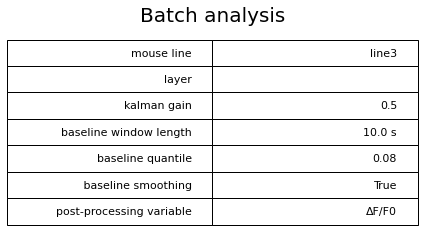

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'baseline window length': f'{baseline_wlen:.1f} s',
    'baseline quantile': baseline_quantile,
    ' baseline smoothing': baseline_smoothing,
    'classification variable': ykey_classification
    }, title='Batch analysis')

### Load data

In [6]:
# Determine exclude patterns
exclude_patterns = None

# Determine what to do in case of duplicate runs
on_duplicate_runs = 'drop'

# Load datasets
logger.info(f'loading data from {trialavg_dir}:')
data = load_trialavg_datasets(
    trialavg_dir, layer=layer, exclude_patterns=exclude_patterns,
    on_duplicate_runs=on_duplicate_runs)

 26/10/2022 18:52:39: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/w10.0s_q0.08_smooth/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main/line3:
 26/10/2022 18:52:39: loading trial-averaged data from 20190704_mouse2_region1.h5
 26/10/2022 18:52:39: loading trial-averaged data from 20190704_mouse3_region1.h5
 26/10/2022 18:52:39: loading trial-averaged data from 20190707_mouse1_region1.h5
 26/10/2022 18:52:39: loading trial-averaged data from 20190807_mouse5_region1.h5
 26/10/2022 18:52:40: loading trial-averaged data from 20190807_mouse6_region1.h5
 26/10/2022 18:52:40: loading trial-averaged data from 20190829_mouse10_region1.h5
 26/10/2022 18:52:40: loading trial-averaged data from 20191107_mouse1_region1.h5
 26/10/2022 18:52:40: loading trial-averaged data from 20191107_mouse1_region2.h5
 26/10/2022 18:52:40: loading trial-averaged data from 20191108_mouse6_region1.h5
 26/10/2022 18:52:40: loading trial-averaged data from 201

### Breakdown per mouse region, cell maps & filter out datasets

 26/10/2022 18:54:16: extracting timeseries and stats from data...
 26/10/2022 18:54:16: extracting responses types per ROI...
 26/10/2022 18:54:16: plotting cells map color-coded by response type...
 26/10/2022 18:54:20: extracting responses types per ROI...
 26/10/2022 18:54:20: plotting cells map color-coded by response type...
 26/10/2022 18:54:23: extracting responses types per ROI...
 26/10/2022 18:54:23: plotting cells map color-coded by response type...
 26/10/2022 18:54:24: extracting responses types per ROI...
 26/10/2022 18:54:24: plotting cells map color-coded by response type...
 26/10/2022 18:54:26: extracting responses types per ROI...
 26/10/2022 18:54:26: plotting cells map color-coded by response type...
 26/10/2022 18:54:29: extracting responses types per ROI...
 26/10/2022 18:54:29: plotting cells map color-coded by response type...
 26/10/2022 18:54:32: extracting responses types per ROI...
 26/10/2022 18:54:32: plotting cells map color-coded by response type...
 2

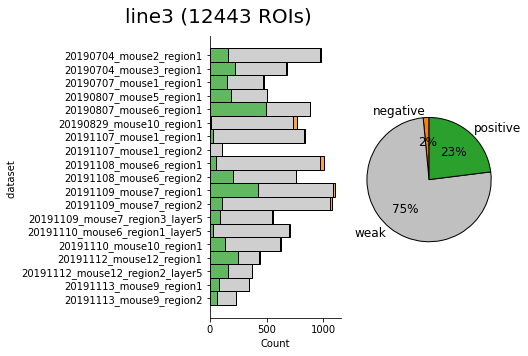

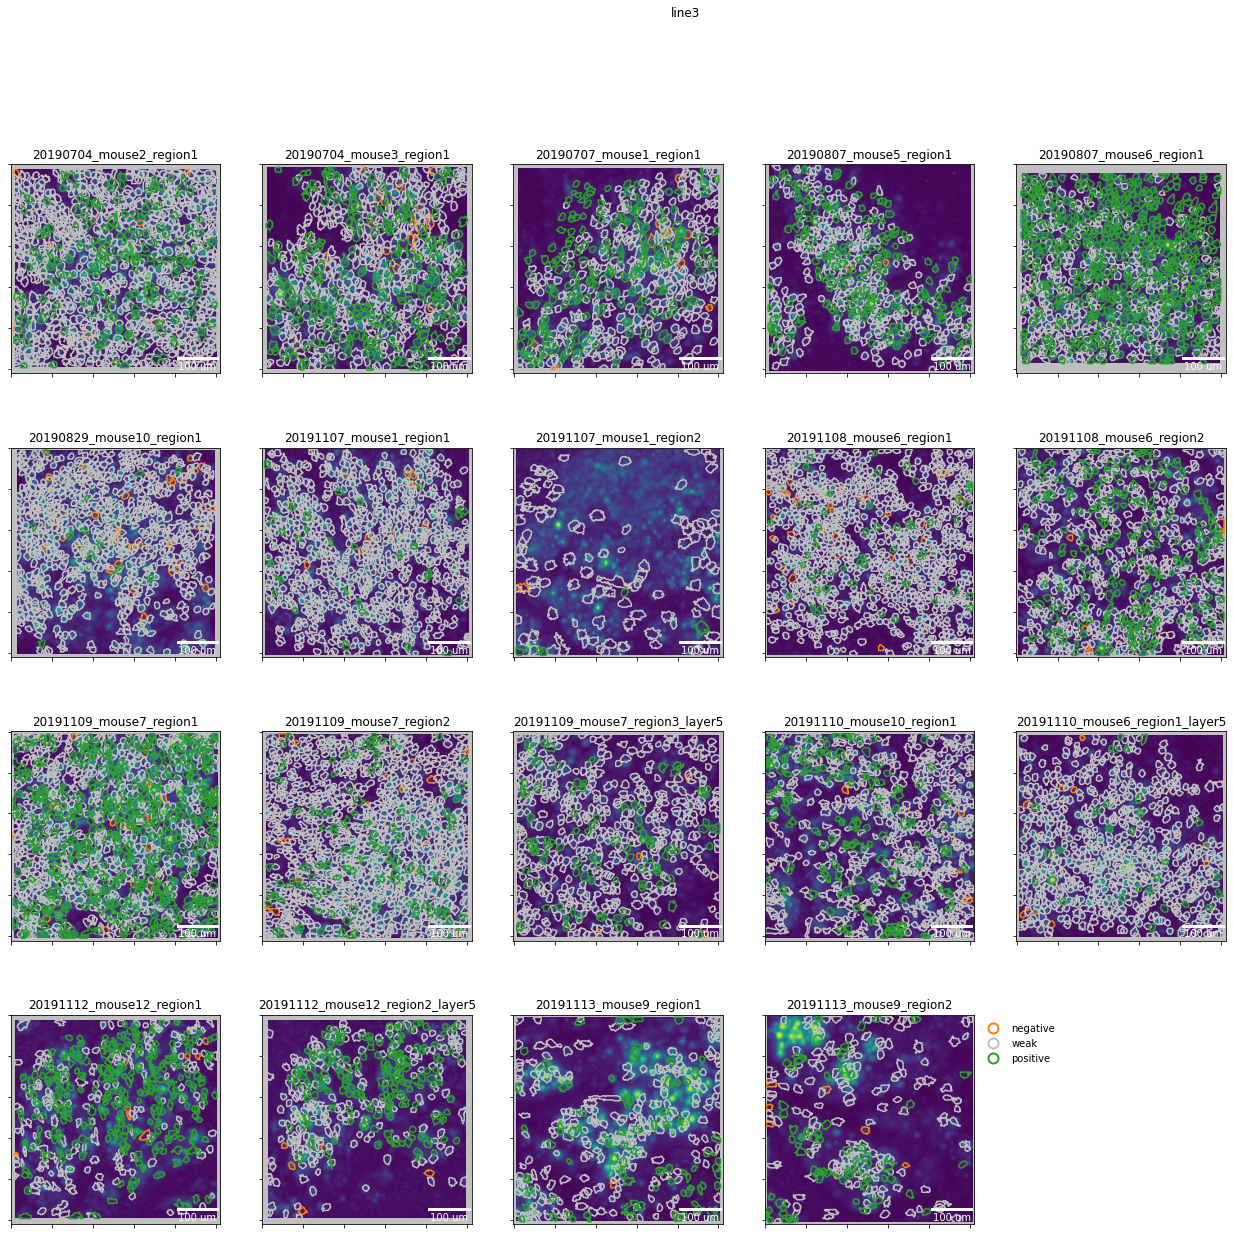

In [7]:
# Extract fields from data
timeseries, stats, ROI_masks, map_ops = extract_from_batch_data(data)
# Plot cell count breakdown
figs['rtype dist per mousereg'] = plot_cellcounts(
    stats, hue=Label.ROI_RESP_TYPE, title=mouseline)
# Plot cell maps
figs['cellmaps'] = plot_cell_maps(
    ROI_masks, stats, map_ops, title=mouseline, refkey='Vcorr', mode='contour')
# Exclude specific datasets
manual_exclude = {
    'line3': [], #'20191109_mouse7_region2'
    'sst': ['20190808_mouse6_region1'],
    'pv': []
}[mouseline]
timeseries, stats = exclude_datasets(timeseries, stats, manual_exclude)

### Plot parameter dependency curves

 26/10/2022 18:55:09: plotting ΔF/F0 stimulation parameters dependencies for negative responders...
 26/10/2022 18:55:12: plotting ΔF/F0 stimulation parameters dependencies for positive responders...
 26/10/2022 18:55:17: plotting ΔF/F0 stimulation parameters dependencies for weak responders...
 26/10/2022 18:55:23: plotting ΔF/F0 stimulation parameters dependencies across responders...
 26/10/2022 18:55:24: plotting event rate (Hz) stimulation parameters dependencies for negative responders...
 26/10/2022 18:55:27: plotting event rate (Hz) stimulation parameters dependencies for positive responders...
 26/10/2022 18:55:32: plotting event rate (Hz) stimulation parameters dependencies for weak responders...
 26/10/2022 18:55:39: plotting event rate (Hz) stimulation parameters dependencies across responders...


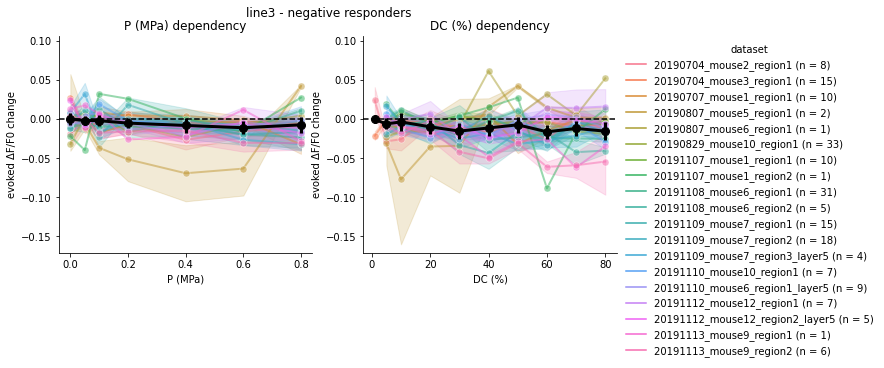

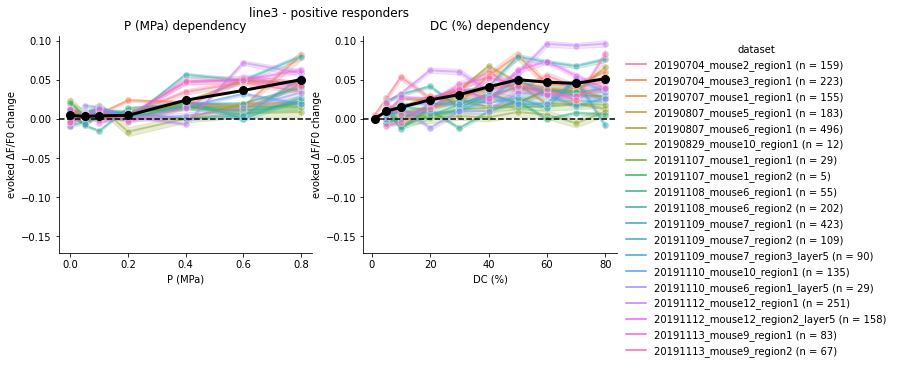

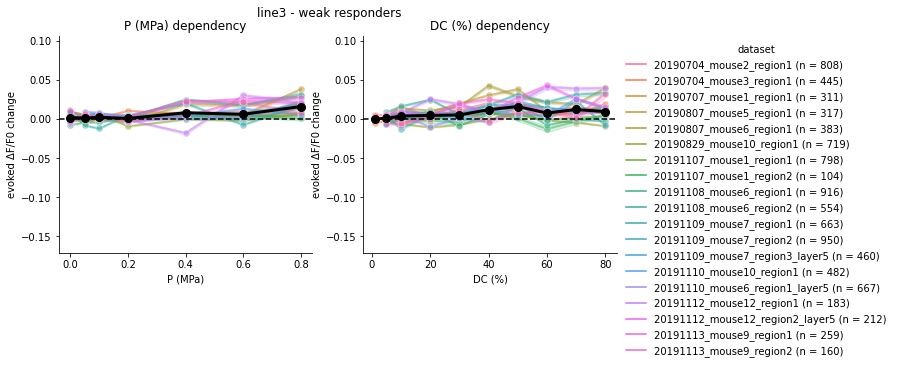

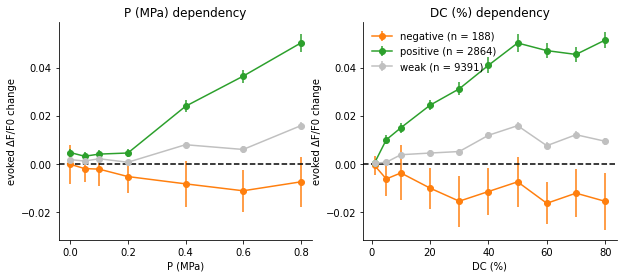

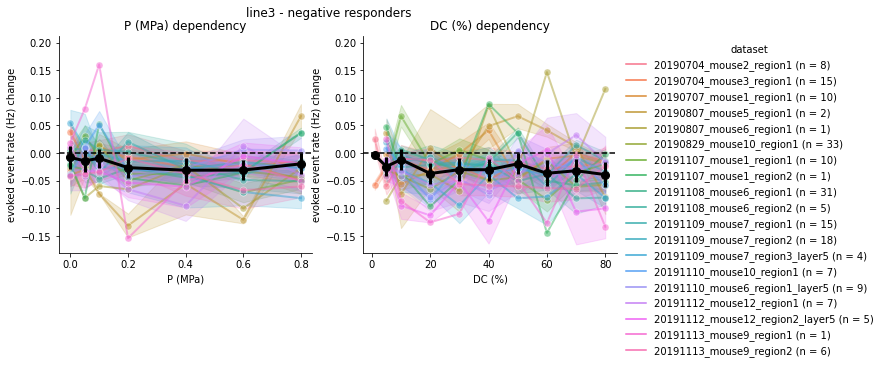

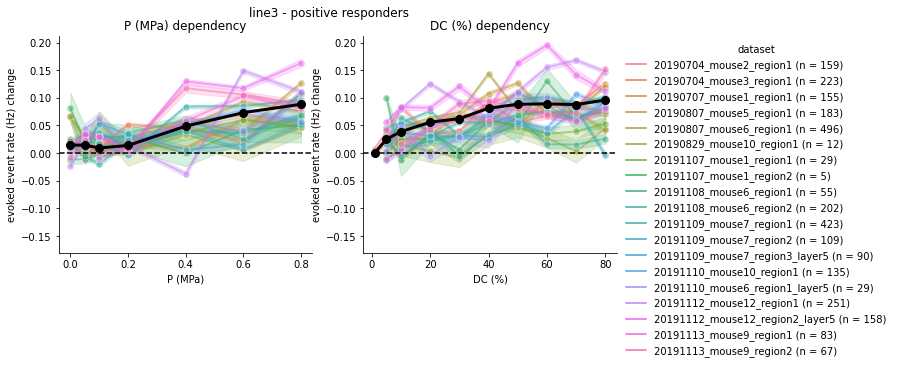

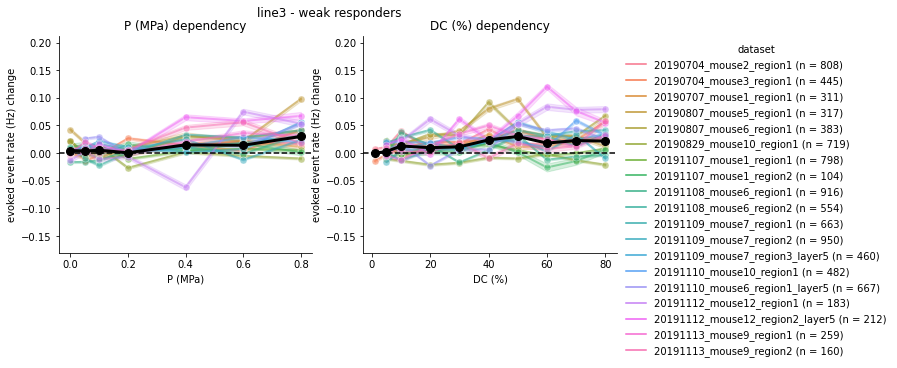

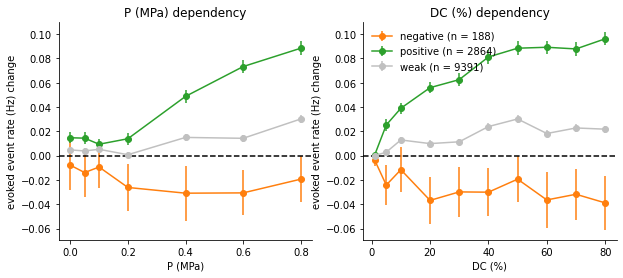

In [8]:
for ykey in [Label.DFF, Label.EVENT_RATE]:
    # Determine output metrics key
    ykey_diff = get_change_key(ykey)

    # Plot param dependencies across datasets for each responder type separately
    tmpaxes = []
    for rtype, substats in stats.groupby(Label.ROI_RESP_TYPE):
        figkey = f'{ykey}_stimparamdeps_{rtype}'
        logger.info(f'plotting {ykey} stimulation parameters dependencies for {rtype} responders...')
        logger.setLevel(logging.WARNING)
        figs[figkey] = plot_stimparams_dependency(
            substats, ykey_diff, yref=0, hue=Label.DATASET, avgprop='whue', errprop='intra')
        figs[figkey].suptitle(f'{mouseline} - {rtype} responders')
        tmpaxes = tmpaxes + figs[figkey].axes
        logger.setLevel(logging.INFO)
    harmonize_axes_limits(np.asarray(tmpaxes))

    # Plot dependencies on each parameter on separate axes
    logger.info(f'plotting {ykey} stimulation parameters dependencies across responders...')
    figs[f'{ykey}_stimparamdeps_global'] = plot_stimparams_dependency(
        stats, hue=Label.ROI_RESP_TYPE, ykey=ykey_diff, yref=0.)

### Plot response traces

In [ ]:
# Get plot-ready traces dataset
plt_data = get_plot_data(timeseries, stats)

for ykey in [Label.DFF, Label.EVENT_RATE]:
    # Pressure-dependent response traces, per dataset
    figs.update(
        plot_responses_across_datasets(plt_data, ykey=ykey, pkey=Label.P))

    # DC-dependent response traces, per dataset
    figs.update(
        plot_responses_across_datasets(plt_data, ykey=ykey, pkey=Label.DC))

    # Global (weighted) response curves for both input stimulation parameters  
    for pkey in [Label.P, Label.DC]:
        figs[f'{ykey} vs. {pkey} by type'] = plot_responses_across_datasets(
            plt_data, ykey=ykey, pkey=pkey, avg=True)

### Save figures

In [9]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 26/10/2022 18:55:40: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.10.26/figs_main_line3_k0.5_w10.0s_q0.08_smooth_ΔFF0.pdf:


100%|██████████| 11/11 [00:09<00:00,  1.22it/s]


### Notify upon completion

In [11]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 26/10/2022 18:50:16: pv batch notebook completed in 0:01:43.133577 s
